In [ ]:
# Deep CNN food classification model

import os
import sys
import shutil
from PIL import Image
from lxml import etree as ET
from tqdm import tqdm
from copy import deepcopy
import tensorflow as tf
import numpy as np
import cv2
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import glob

Populating the interactive namespace from numpy and matplotlib


In [139]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [79]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer, Dense, Reshape, Lambda, Dropout, LeakyReLU, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
# from keras.utils import layer_utils
from tensorflow.keras.utils import Sequence
# from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras_applications.imagenet_utils import _obtain_input_shape
# from keras.engine.topology import get_source_inputs
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [82]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K

Using TensorFlow backend.


In [ ]:
print("Tensorflow {}".format(tf.__version__))
print("Keras {}".format(keras.__version__))

Tensorflow 2.2.0
Keras 2.3.0-tf


# Initialization

In [ ]:
BASE_PATH = '/content/drive/My Drive/Food-Dataset/' #'/kaggle/input/' 
# LABELS = ['rice', 'roti', 'dal', 'sabzi']
LABELS = ['rice', 'roti', 'dal', 'sabzi']
 
# IMAGE_H = 224
# IMAGE_W = 224 # must equal to GRID_H * 32  416, 416
# GRID_H, GRID_W = 7, 7        # 13, 13
# N_BOX = 5
# CLASS = len(LABELS)
# CLASS_WEIGHTS = np.ones(4, dtype='float32')
# OBJ_THRESHOLD = 0.3
# NMS_THRESHOLD = 0.3
 
# NO_OBJECT_SCALE = 1.0
# OBJECT_SCALE = 5.0
# COORD_SCALE = 1.0
# CLASS_SCALE = 1.0
 
# BATCH_SIZE = 64
# WARM_UP_BATCHES = 0
# TRUE_BOX_BUFFER = 50
# LAMBDA_NO_OBJECT = 1.0
# LAMBDA_OBJECT    = 5.0
# LAMBDA_COORD     = 1.0
# LAMBDA_CLASS     = 1.0

In [ ]:
generator_config = {
    'IMAGE_H': IMAGE_H,
    'IMAGE_W': IMAGE_W,
    'GRID_H': GRID_H,
    'GRID_W': GRID_W,
    'BOX': N_BOX,
    'LABELS': LABELS,
    'CLASS': len(LABELS),
     # 'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

# Building CNN Model

In [ ]:
def get_alexnet(input_shape, nb_classes): 
    model = Sequential() 
    # Layer 1 
    model.add(Convolution2D(96, 11, 11, input_shape = input_shape, border_mode='same')) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    # Layer 2 
    model.add(Convolution2D(128, 5, 5, border_mode='same')) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2)) 
    # Layer 3 
    model.add(ZeroPadding2D((1,1))) 
    model.add(Convolution2D(384, 3, 3, border_mode='same')) 
    model.add(Activation('relu')) 
    # Layer 4 
    model.add(ZeroPadding2D((1,1))) 
    model.add(Convolution2D(192, 3, 3, border_mode='same')) 
    model.add(Activation('relu')) 
    # Layer 5 
    model.add(ZeroPadding2D((1,1))) 
    model.add(Convolution2D(128, 3, 3, border_mode='same')) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    # Layer 6 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(4096, init='glorot_normal')) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    # Layer 7 
    model.add(Dense(4096, init='glorot_normal')) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    # Layer 8 
    model.add(Dense(nb_classes, init='glorot_normal')) 
    model.add(Activation('tanh')) 
    return model

# Loading data

In [ ]:
from tqdm import tqdm
from collections import Counter

In [ ]:
# os.listdir(BASE_PATH)[:40]

['740.jpg',
 '1344.jpg',
 '532.jpg',
 '548.jpg',
 '374.jpg',
 '32.jpg',
 '628.jpg',
 '555.jpg',
 '282.jpg',
 '1099.jpg',
 '209.jpg',
 '1043.jpg',
 '768.jpg',
 '1212.jpg',
 '936.jpg',
 '311.jpg',
 '334.jpg',
 '324.jpg',
 '935.jpg',
 '296.jpg',
 '1463.jpg',
 '1193.jpg',
 '1154.jpg',
 '265.jpg',
 '672.jpg',
 '1445.jpg',
 '1143.jpg',
 '219.jpg',
 '1244.jpg',
 '256.jpg',
 '670.jpg',
 '792.jpg',
 '1078.jpg',
 '1511.jpg',
 '1024.jpg',
 '157.jpg',
 '1346.jpg',
 '316.jpg',
 '15.jpg',
 '1494.jpg']

In [ ]:
all_images = []
# train_labels = [] 

    # for f in os.listdir(os.path.join(BASE_PATH, "Dataset", str(i))):
for f in tqdm(glob.glob(os.path.join(BASE_PATH, "*.jpg"))):
    img = cv2.imread(f, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (227, 227))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    all_images.append((f[f.rfind('/')+1:], img))

# len(set(train_images))

100%|██████████| 1575/1575 [00:08<00:00, 177.36it/s]


In [ ]:
# len(all_images)
# d = [i[0] for i in all_images]
# for i in range(10):
#     print(i in list(Counter(d).values()))

False
True
False
False
False
False
False
False
False
False


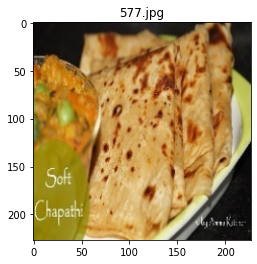

In [ ]:
plt.imshow(all_images[50][1])
plt.title(all_images[50][0])
plt.show()

In [ ]:
all_labels = []
with open(os.path.join(BASE_PATH, 'new_annotations_onehot_1.txt'), 'r') as f:
    
    lines = f.readlines()
    for line in lines:
        line = line.rstrip('\n')
        
        fname, lab = line.split(' ')
        print('fname {} lab {}'.format(fname, lab))
        all_labels.append((fname, lab))

print(len(all_labels))
print(all_labels[50])

fname 1.jpg lab 1.0
fname 10.jpg lab 13.0
fname 100.jpg lab 4.0
fname 1000.jpg lab 8.0
fname 1001.jpg lab 1.0
fname 1002.jpg lab 1.0
fname 1003.jpg lab 8.0
fname 1004.jpg lab 8.0
fname 1005.jpg lab 2.0
fname 1006.jpg lab 10.0
fname 1007.jpg lab 13.0
fname 1008.jpg lab 8.0
fname 1009.jpg lab 10.0
fname 101.jpg lab 11.0
fname 1010.jpg lab 8.0
fname 1011.jpg lab 4.0
fname 1012.jpg lab 12.0
fname 1013.jpg lab 1.0
fname 1014.jpg lab 2.0
fname 1015.jpg lab 1.0
fname 1016.jpg lab 10.0
fname 1017.jpg lab 11.0
fname 1018.jpg lab 1.0
fname 1019.jpg lab 2.0
fname 102.jpg lab 1.0
fname 1020.jpg lab 2.0
fname 1021.jpg lab 2.0
fname 1022.jpg lab 5.0
fname 1023.jpg lab 2.0
fname 1024.jpg lab 9.0
fname 1025.jpg lab 1.0
fname 1026.jpg lab 13.0
fname 1027.jpg lab 11.0
fname 1028.jpg lab 10.0
fname 1029.jpg lab 1.0
fname 103.jpg lab 8.0
fname 1030.jpg lab 4.0
fname 1031.jpg lab 5.0
fname 1032.jpg lab 11.0
fname 1033.jpg lab 1.0
fname 1034.jpg lab 4.0
fname 1035.jpg lab 1.0
fname 1036.jpg lab 8.0
fname 10

In [ ]:
for i in all_labels:
    filename = i[0]

In [ ]:
# d = set()
# for i in tqdm(train_images):
#     if i[0] not in d:
#         d.add(i[0])

# print(len(d))           

100%|██████████| 2381/2381 [00:00<00:00, 553675.10it/s]

1568


In [ ]:
# Mapping between images and labels
lnames = [f[0] for f in all_labels]
for l in all_images:
    if l[0] not in lnames:
        print(l[0])
to_remove = ['782.jpg', '803.jpg', '615.jpg', '880.jpg', '671.jpg', '607.jpg', '1146.jpg'] 
all_images_filter = []
for i in tqdm(all_images):
    if i[0] not in to_remove:
        all_images_filter.append(i) 


100%|██████████| 1575/1575 [00:00<00:00, 585848.60it/s]

782.jpg
803.jpg
615.jpg
880.jpg
671.jpg
607.jpg
1146.jpg


In [ ]:
dataset = []
import pandas as pd

df1 = pd.DataFrame(all_labels)
df1.rename(columns={0: 'filename', 1: 'label'}, inplace=True)

df2 = pd.DataFrame(all_images_filter)
df2.rename(columns={0: 'filename', 1: 'image'}, inplace=True)

df1.columns

Index(['filename', 'label'], dtype='object')

In [ ]:
x = df1.merge(df2, on='filename')
print(x.head())
print(len(x))
print(len(all_images_filter))

   filename label                                              image
0     1.jpg   1.0  [[[239, 218, 175], [239, 218, 175], [240, 219,...
1    10.jpg  13.0  [[[33, 33, 35], [33, 33, 35], [33, 33, 35], [3...
2   100.jpg   4.0  [[[219, 218, 216], [219, 218, 216], [219, 218,...
3  1000.jpg   8.0  [[[44, 25, 18], [45, 26, 19], [49, 30, 24], [4...
4  1001.jpg   1.0  [[[8, 61, 139], [8, 61, 139], [9, 62, 140], [1...
1568
1568


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
dataset = x[['image', 'label']]
train_images, test_images, train_labels, test_labels = train_test_split(dataset['image'], dataset['label'], test_size=0.2, shuffle=True)
train_images, test_images, train_labels, test_labels = list(train_images), list(test_images), list(map(float, list(train_labels))), list(map(float, list(test_labels)))

# CNN for feature extraction

In [ ]:
train_images[0].shape

(227, 227, 3)

In [83]:
alexnet = get_alexnet((227,227,3),15)
alexnet.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), input_shape=(227, 227,..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 227, 227, 96)      34944     
_________________________________________________________________
activation_1 (Activation)    (None, 227, 227, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     307328    
_________________________________________________________________
activation_2 (Activation)    (None, 113, 113, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 58, 58, 128)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, kernel_initializer="glorot_normal")`


In [100]:
alexnet.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
X_normalized = np.array(np.asarray(train_images) / 255.0 - 0.5 )
X_normalized_test = np.array(np.asarray(test_images) / 255.0 - 0.5 )

# label_binarizer = LabelBinarizer()
# y_one_hot = label_binarizer.fit_transform(train_labels)
# y_one_hot_test = label_binarizer.fit_transform(test_labels)
# print(y_one_hot[0])

y_one_hot = np.zeros(shape=(len(train_labels), 15))
y_one_hot_test = np.zeros(shape=(len(test_labels), 15))

for i in range(len(train_labels)):
    y_one_hot[i][int(train_labels[i])-1] = 1
for i in range(len(test_labels)):
    y_one_hot_test[i][int(test_labels[i])-1] = 1

In [95]:
p = np.zeros((15, 100))
print(p.shape)
print(len(p))

(15, 100)
15


In [93]:
train_labels[0]
print(y_one_hot[:100])
print(y_one_hot[1].__len__())

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
15


In [101]:
alexnet.fit(X_normalized, y_one_hot, batch_size=5, epochs=2,verbose=1, validation_data=[X_normalized_test,y_one_hot_test])

Train on 1254 samples, validate on 314 samples
Epoch 1/2
1254/1254 [==============================] - 1348s 1s/step - loss: 4.9713 - accuracy: 0.1842 - val_loss: 5.2871 - val_accuracy: 0.2006
Epoch 2/2
1254/1254 [==============================] - 1331s 1s/step - loss: 4.8329 - accuracy: 0.1842 - val_loss: 5.2871 - val_accuracy: 0.2006


In [102]:
alexnet.save(os.path.join(BASE_PATH, 'alexnet_food_model.h5'))

# Extending CNN model to RF

In [103]:
layer_name = 'dense_1'
FC_layer_model = Model(inputs=alexnet.input,
                                 outputs=alexnet.get_layer(layer_name).output)

In [107]:
assert (len(train_images) == np.asarray(train_images).shape[0])

In [109]:
#Find the Features for n number of train images and we will get n x 4096
#This means we will get 4096 features for each images.
i=0
features=np.zeros(shape=(len(train_images), 4096))
for _img in tqdm(train_images):
    # img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
    # img = cv2.resize(img, (227, 227))
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(_img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features[i]=FC_output
    i+=1

100%|██████████| 1254/1254 [05:22<00:00,  3.89it/s]


In [110]:
#Save the features of the train images to use it in future.
np.save(os.path.join(BASE_PATH, 'features'), features)

In [111]:
feature_col=[]
for i in range(4096):
    feature_col.append("f_"+str(i))
    i+=1

In [114]:
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(train_labels))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', np.asarray(train_labels).shape)
train_class

Training Features Shape: (1254, 4096)
Training Labels Shape: (1254,)


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0]

In [118]:
# train labe ids and test label ids
print(type(train_labels))
train_label_ids = [np.uint(tl) for tl in train_labels]
test_label_ids = [np.uint(tl) for tl in test_labels]
train_label_ids[:10]

<class 'list'>


[8, 1, 9, 15, 1, 13, 8, 2, 2, 8]

## Random Forest Classifier

In [119]:
rf = RandomForestClassifier(n_estimators = 20, random_state = 42, max_features=4)

rf.fit(train_features, train_label_ids)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Novel algo

In [124]:

from tqdm.notebook import tqdm
i=0
features_test=np.zeros(shape=(len(test_images), 4096))
for _img in tqdm(test_images):
    # img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
    img = cv2.resize(_img, (227, 227))
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features_test[i]=FC_output
    i+=1    

In [125]:
test_images[313].shape

(227, 227, 3)

In [128]:
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', np.asarray(test_label_ids).shape)

Test Features Shape: (314, 4096)
Test Labels Shape: (314,)


### Classification by Random Forest

In [137]:
#Feed the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)

In [138]:
accuracy=accuracy_score(predictions , test_label_ids)
print('Accuracy:', accuracy*100, '%.')

Accuracy: 34.71337579617834 %.


In [162]:
def dec2bin(num):
    return bin(num)

def get_classes(prediction):
    class_decodings = {"rice": 0b1000, "roti": 0b0100, "dal": 0b0010, "sabzi": 0b0001}
    bin_pred = int(dec2bin(prediction), 2)
    classes = []
    for i, j in class_decodings.items():
        if ((bin_pred) & j) == j:
             classes.append(i)
    return classes         


## Predictions on Images

It's  ['rice', 'dal', 'sabzi']


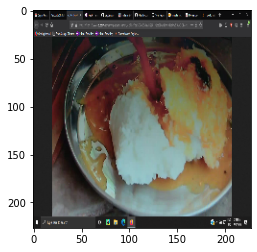

In [163]:
img_path=os.path.join(BASE_PATH, "test_image_3.png")
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's ",get_classes(predictions[0]))